# Unsupervised learning

Import usefull packages + the njord library. For installations details please refer to README file. 

In [1]:
import njord as nj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hyper parameters

In [2]:
# Dataset parameters.
PATH = "dataset"
SYMBOL = "btcusdt"
DATASET = "ohlc"
PERIOD = 1800
FILENAME_TR = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "train")
FILENAME_TE = "binance_{}_{}_period_{}_{}.csv".format(SYMBOL, DATASET, PERIOD, "test")

# Batch parameters.
LOOKBACK = 16
LOOKAHEAD = 1
TARGET = "close"

# Training parameters.
LR = 0.0001
EPOCHS = 100
MINIBATCH_SIZE = 128

## Dataset

Load the dataset from .csv file to a pandas dataframe.

In [3]:
# Load the training dataset.
data_tr = pd.read_csv(PATH + "/" + FILENAME_TR)
data_tr = data_tr.set_index("time")
data_tr.index = pd.to_datetime(data_tr.index)

# Load the test dataset.
data_te = pd.read_csv(PATH + "/" + FILENAME_TE)
data_te = data_te.set_index("time")
data_te.index = pd.to_datetime(data_te.index)

In [4]:
# Display the number of samples for the datasets.
print("Number of samples train = {}".format(data_tr.shape))
print("Number of samples test = {}".format(data_te.shape))

# Display the head of the dataset.
print("\n training head: \n{}".format(data_tr.head()))
print("\n test head: \n{}".format(data_te.head()))

Number of samples train = (2928, 5)
Number of samples test = (912, 5)

 training head: 
                        open     high      low    close          avg
time                                                                
2018-09-01 00:30:00  7011.21  7046.00  7010.00  7046.00  7035.944180
2018-09-01 01:00:00  7046.00  7049.91  7030.00  7044.59  7040.916360
2018-09-01 01:30:00  7043.96  7061.01  7041.85  7046.05  7051.093408
2018-09-01 02:00:00  7046.12  7052.67  7032.19  7036.00  7043.653567
2018-09-01 02:30:00  7037.00  7059.90  7034.32  7054.47  7047.259786

 test head: 
                        open     high      low    close          avg
time                                                                
2018-11-01 00:30:00  6371.93  6376.99  6360.77  6366.25  6372.322671
2018-11-01 01:00:00  6366.56  6371.68  6355.00  6366.00  6363.326981
2018-11-01 01:30:00  6369.66  6370.17  6361.81  6363.18  6365.797962
2018-11-01 02:00:00  6364.99  6365.00  6358.04  6358.24  6362.124753
2

## Batch and data normalisation

We now have to build the batch, i.e. a feature array X with its associated targets Y. 

- The timeseries X are normalise with the pivot method.

In [5]:
# Load the training and test batch.
batch_tr = nj.Batch(data_tr, LOOKBACK, LOOKAHEAD)
batch_te = nj.Batch(data_te, LOOKBACK, LOOKAHEAD)

# Build the training and test batch to get the features and the targets.
X_tr, _ = batch_tr.build(target="avg", method="pct")
X_te, _ = batch_te.build(target="avg", method="pct")


In [6]:
# Display features information.
print("\nTraining Features info:")
print("X_tr shape = {}".format(X_tr.shape))
print("X_tr mean  = {}".format(X_tr.mean()))
print("X_tr std   = {}".format(X_tr.std()))
print("\nTest Features info:")
print("X_te shape = {}".format(X_te.shape))
print("X_te mean  = {}".format(X_te.mean()))
print("X_te std   = {}".format(X_te.std()))


Training Features info:
X_tr shape = (2896, 16, 5)
X_tr mean  = -0.026140004437851947
X_tr std   = 1.0127101900481856

Test Features info:
X_te shape = (880, 16, 5)
X_te mean  = -0.19277473119092509
X_te std   = 1.0599736488697409


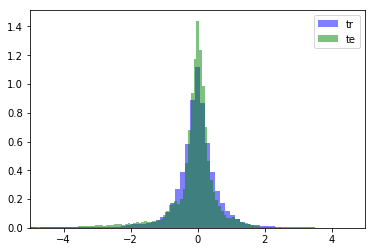

In [7]:
# Histogram: Train and test Features.
hist_X_tr = plt.hist(X_tr.reshape(-1, 1), 200, density=True, facecolor="b", alpha=0.50, label="tr")
hist_X_te = plt.hist(X_te.reshape(-1, 1), 200, density=True, facecolor="g", alpha=0.50, label="te")
plt.xlim([-5, 5])
plt.legend()
plt.show()

## Training

Train a model with keras.

In [8]:
# Import usefull packages.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
import keras.backend as K

Using TensorFlow backend.


In [ ]:
# Reshape the training dataset.
X_train = X_tr.reshape(X_tr.shape[0], -1)

# Reshape the test dataset.
X_test = X_te.reshape(X_te.shape[0], -1)

# Build the model.
model = Sequential()
model.add(Dense(units=128, activation="relu", input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="linear"))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=X_train.shape[1], activation="linear"))

# Set the optimizer.
optimizer = optimizers.Adam(lr=0.00025, epsilon=1.0E-6, decay=0.0)

# Compile the model.
model.compile(loss="mean_squared_error", optimizer=optimizer)

# Set the training parameters.
params = {
    "epochs": 500,
    "batch_size": 32,
    "validation_data": (X_test, X_test),
    "shuffle": True,
    "verbose": 1
}

# Train the model.
history = model.fit(X_train, X_train, **params)

# Training finished.
print("Training finished")

Train on 2896 samples, validate on 880 samples
Epoch 1/500
2896/2896 [==============================] - 2s 637us/step - loss: 1.1598 - val_loss: 1.1074
Epoch 2/500
2896/2896 [==============================] - 0s 146us/step - loss: 1.0262 - val_loss: 1.0162
Epoch 3/500
2896/2896 [==============================] - 0s 130us/step - loss: 0.9072 - val_loss: 0.7037
Epoch 4/500
2896/2896 [==============================] - 0s 136us/step - loss: 0.7789 - val_loss: 0.5534
Epoch 5/500
2896/2896 [==============================] - 0s 167us/step - loss: 0.6957 - val_loss: 0.5350
Epoch 6/500
2896/2896 [==============================] - 0s 123us/step - loss: 0.6402 - val_loss: 0.4722
Epoch 7/500
2896/2896 [==============================] - 0s 146us/step - loss: 0.6082 - val_loss: 0.4757
Epoch 8/500
2896/2896 [==============================] - 0s 133us/step - loss: 0.5673 - val_loss: 0.4605
Epoch 9/500
2896/2896 [==============================] - 0s 129us/step - loss: 0.5653 - val_loss: 0.4075
Epoch 10

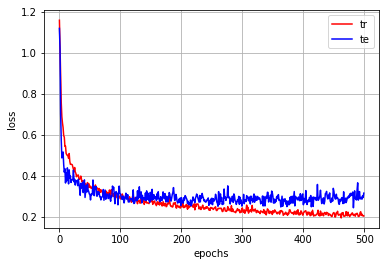

In [25]:
# Figure: loss vs epochs.
plt.figure()
plt.plot(history.history["loss"], label="tr", color="r")
plt.plot(history.history["val_loss"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

## Evaluation of the model

In [ ]:
# Evaluate the model on th train set.
eval_tr = model.evaluate(X_train, X_train, verbose=2)

# Evaluate the model on th test set.
eval_te = model.evaluate(X_test, X_test, verbose=2)

# Display the results.
print("Evaluate model on the training set: \n {}".format(eval_tr))
print("Evaluate model on the test set: \n {}".format(eval_te))

In [ ]:
# The number of sequences to display.
n = 1

# Get the predictions of the model.
X_te_p = model.predict(X_test)

# Reshape the features and predictions.
X_te_s = X_test.reshape(X_test.shape[0], LOOKBACK, -1)
X_te_p = X_te_p.reshape(X_test.shape[0], LOOKBACK, -1)

In [ ]:
# Compute the residuals.
res = ( X_te_s - X_te_p)

# Compute the average error.
err = np.sqrt(np.mean( res * res, axis=(1, 2)))

# Compute the maximum and minimum error.
err_max = err.max()
err_min = err.min()
err_amax = err.argmax()
err_amin = err.argmin()
print("Maximum error = {}, index = {}".format(err_max, err_amax))
print("Minimum error = {}, index = {}".format(err_min, err_amin))

# Figure 1: MSE vs. steps.
plt.figure(figsize=(20, 5))
plt.plot(err, color="b")
plt.xlabel("steps")
plt.ylabel("MSE")
plt.grid()
plt.show()

# Figure 2: MSE histograme
plt.figure(figsize=(20, 5))
histogram = plt.hist(err, 100, density=True, facecolor="b", alpha=0.75, label="te")
plt.show()

In [ ]:
# Figure: Worst case.
plt.figure(figsize=(12, 4))
plt.plot(X_te_s[err_amax,:,4], color="b", label="true")
plt.plot(X_te_p[err_amax,:,4], color="r", label="pred")
plt.xlabel("time")
plt.ylabel("scaled price")
plt.title("Error = {}, index = {}".format(round(err_max, 3), err_amax))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Figure: Best case.
n = 4
plt.figure(figsize=(12, 20))
for i in range(n):
    ax = plt.subplot(n, 1, i + 1)
    plt.plot(X_te_s[i,:,0], color="b", label="true")
    plt.plot(X_te_p[i,:,0], color="r", label="pred")
    ax.set_xlabel("time")
    ax.set_ylabel("price")
    ax.grid()
plt.show()